# Assignment1

## TASK 1: DATA PREPARATION

### TASK 1A: EXPLORATORY DATA ANALYSIS

#### 1. Library import & Global var definition

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
file_path = 'Assignment1/dataset/dataset_mood_smartphone.csv'
save_path = 'Assignment1/dataset/dataset_mood_smartphone_reshape.csv'

In [35]:
continuous_variables = [
    'circumplex.arousal',
    'circumplex.valence',
    'activity',
    # 'screen',
    # 'appCat.builtin',
    # 'appCat.communication',
    'appCat.entertainment',
    # 'appCat.finance',
    # 'appCat.game',
    # 'appCat.office',
    # 'appCat.other',
    'appCat.social',
    # 'appCat.travel',
    # 'appCat.unknown',
    'appCat.utilities',
    'appCat.weather'
]

categorical_variables = ['call', 'sms']

#### 2. Reading and Preparing the Data

In [24]:
def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

def time_to_datetime(data):
    data['time'] = pd.to_datetime(data['time']).dt.date
    return data

def reshape_data_with_id(data):
    # data = time_to_datetime(data)
    df = pd.DataFrame(data)
    # reshape the data
    df_pivoted = df.pivot_table(index=['id', 'time'], columns='variable', values='value').reset_index()
    return df_pivoted

def reshape_data(data):
    data = time_to_datetime(data)
    df = pd.DataFrame(data)
    # reshape the data
    df_pivoted = df.pivot_table(index='time', columns='variable', values='value').reset_index()
    return df_pivoted

def calculate_daily_mood_mean(data):
    df = pd.DataFrame(data)
    daily_mood_mean = df.groupby(['id','time','variable'])['value'].mean().reset_index()
    return daily_mood_mean

def save_to_csv(data, file_path):
    data.to_csv(file_path, index=False)

In [21]:
# read data
data = read_csv(file_path)
# convert time to date
data = time_to_datetime(data)
# calculate daily average
data = calculate_daily_mood_mean(data)


# reshape data without id column
data_without_id = reshape_data(data)
# reshape data with id column
data_with_id = reshape_data_with_id(data)

# save the processed date
save_to_csv(data_with_id, save_path)

#### 3. Data Analysis and Visualization

**Defining Functions**

In [ ]:
# Time Series Plot for mood over time
def plot_time_series(data, x, y):
    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, x=x, y=y)
    plt.title('Mood Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mood Score')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.show()

# Bar chart for mood vs. call
def plot_bar_chart(data, x, y):
    sns.barplot(data=data, x=x, y=y)
    plt.title('Mood and Call Made')
    plt.xlabel('Call Made (0 = No, 1 = Yes)')
    plt.ylabel('Average Mood Score')
    plt.show()

# boxplot for classification variables
def plot_boxplot(data):
    # categorical_variables = ['call', 'sms']
    # for var in categorical_variables:
    #     sns.boxplot(x=data[var], y=data['mood'])
    #     plt.title(f'Mood by {var}')
    #     plt.xlabel(var)
    #     plt.ylabel('Mood')
    #     plt.show()
    fig, axes = plt.subplots(nrows=1, ncols=len(categorical_variables), figsize=(10, 5))
    
    for i, var in enumerate(categorical_variables):
        sns.boxplot(x=data[var], y=data['mood'], ax=axes[i])
        axes[i].set_title(f'Mood by {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Mood')
    
    plt.tight_layout()
    plt.show()

# scatter plot for continuous variables
def plot_scatter(data):
    for var in continuous_variables:
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('time')
        ax1.set_ylabel('mood', color=color)
        ax1.plot(data['time'], data['mood'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel(var, color=color)
        ax2.scatter(data['time'], data[var], color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

# heatmap for correlation matrix
def plot_heatmap(data):
    correlation_matrix = data[continuous_variables + ['mood']].corr()
    sns.heatmap(correlation_matrix, annot=True)
    plt.title('Correlation Matrix')
    plt.figure(figsize=(16, 8))
    plt.show()

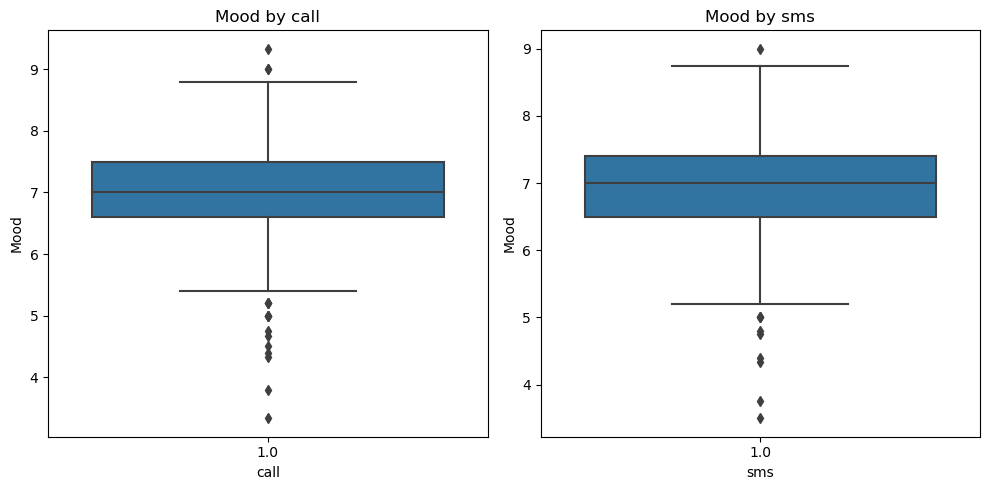

NameError: name 'df' is not defined

In [28]:
plot_boxplot(data_with_id)
plt.show()

In [ ]:
# read data
data = read_csv(file_path)
# reshape data have exact time
data_with_time = reshape_data_with_id(data)
print(data_with_time.head())
plot_time_series(data_with_time, 'time', 'mood')

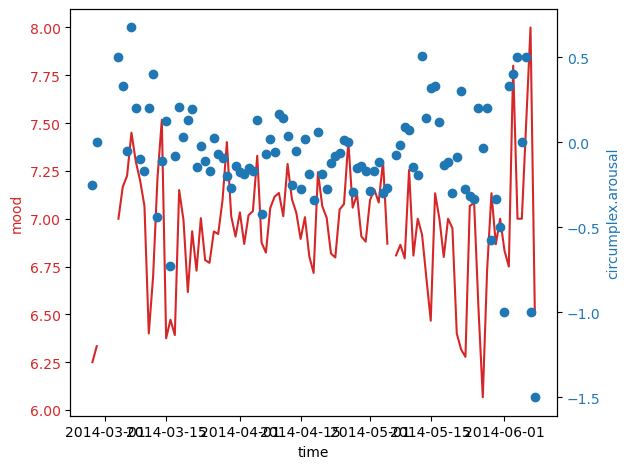

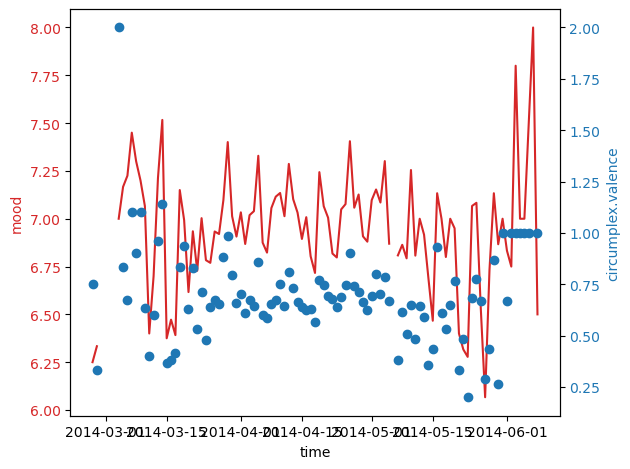

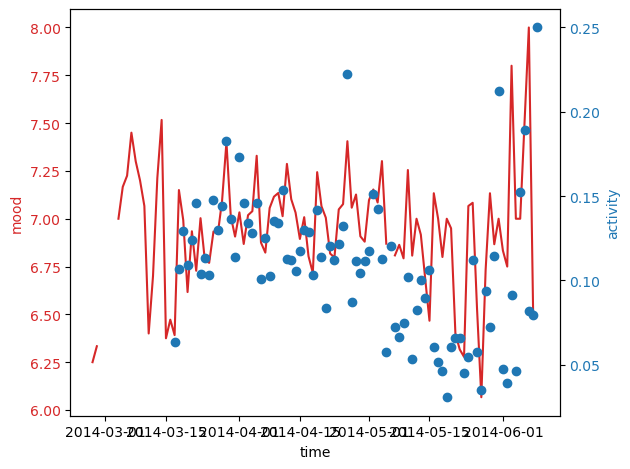

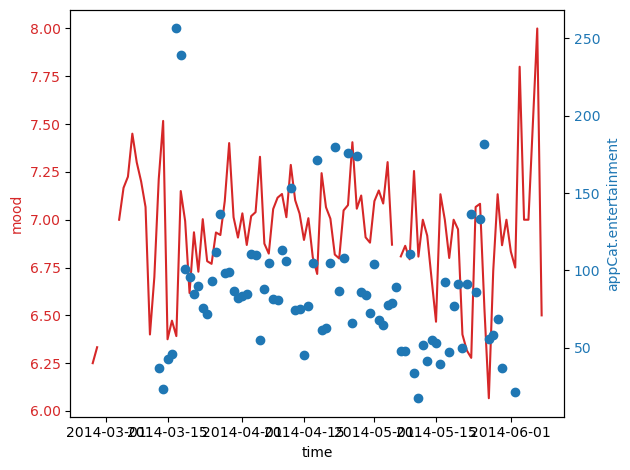

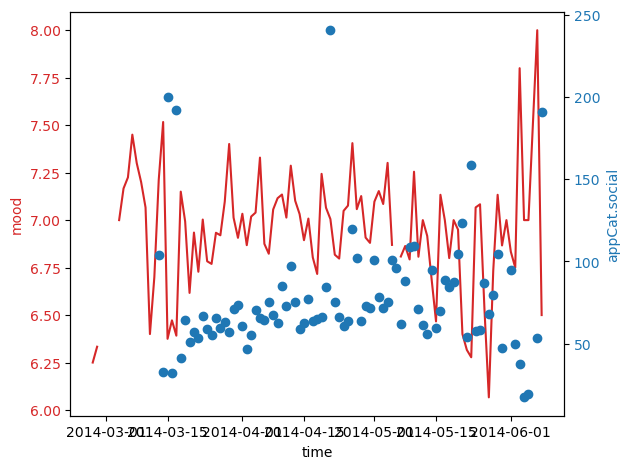

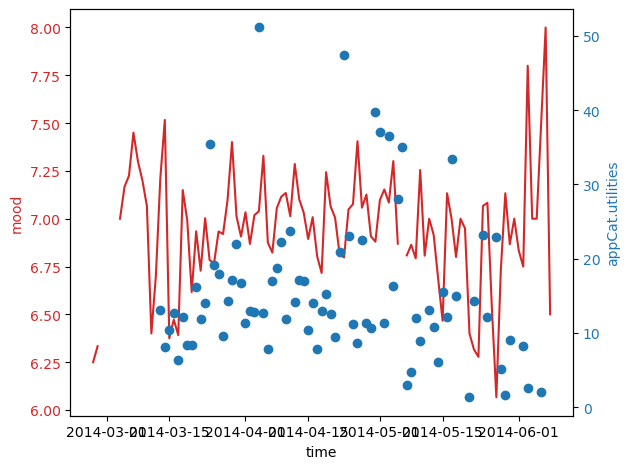

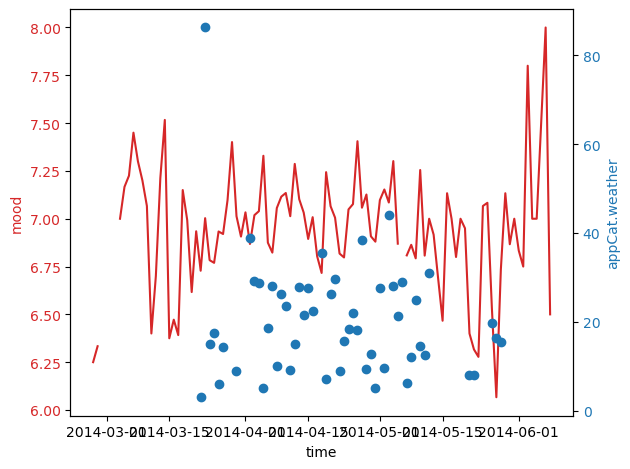

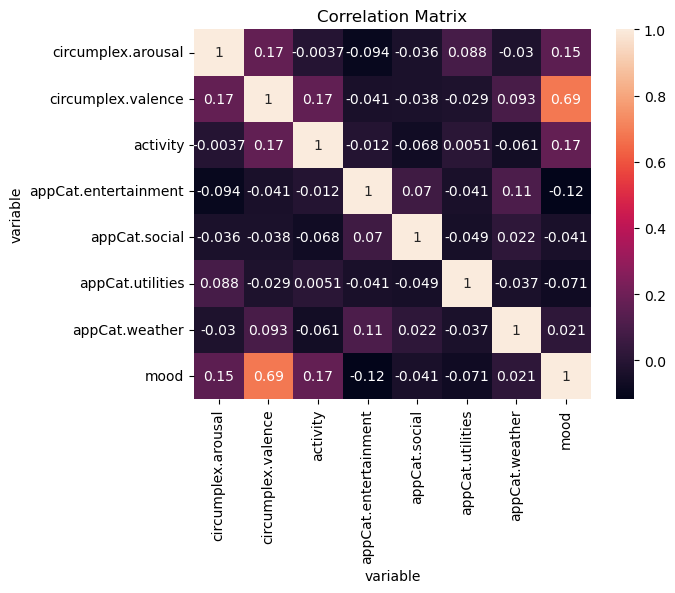

<Figure size 1600x800 with 0 Axes>

In [36]:
plot_scatter(data_without_id)
plot_heatmap(data_with_id)

### TASK 1B: DATA CLEANING
**In this step, we choose two approaches to impute missing values that are logical for such time series:**


1.   Approach1(TODO)
2.   Approach2(TODO)



Clean the rows only have call and sms

In [38]:
# Define the columns to check
columns_to_check = ['id', 'time', 'sms', 'call']

# Create a mask where for each row, if 'id' and 'time' are not NA and either 'sms' or 'call' is not NA, the row is True
mask = data_with_id[['id', 'time']].notna().all(axis=1) & data_with_id[['sms', 'call']].notna().any(axis=1)

# Invert the mask, to get rows where either 'id', 'time' are NA or both 'sms' and 'call' are NA
mask = ~mask

# Apply the mask to the dataframe
data_with_id = data_with_id[mask]

# Save the result to a new csv
data_with_id.to_csv('dataset_mood_smartphone_reshape_cleaned.csv', index=False)

### TASK 1C: FEATURE ENGINEERING